# GROUP PROJECT PROPOSAL

## Introduction:
**Provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your proposal**

  Classification is the process in which data is grouped into categories based on their properties. Then when presented with new data, we can use the old data to accurately predict the class of the new data. In this proposal we will state the dataset we are going to perform classification on and demonstrate preliminary data analysis while providing context as to how the process will be done and what we are expecting to find. etc.

**Clearly state the question you will try to answer with your project**

  Is there a correlation between the rank, height, age, and the hand of which a player plays? (i.e. we classify if a player is left or right handed based on the three predictors)
	
 **Identify and describe the dataset that will be used to answer the question**

The dataset we will be using is Player Stats for Top 500 Players. 


## Preliminary exploratory data analysis:


In [68]:
library(tidyverse)
library(repr)
library(tidymodels)
library(RColorBrewer)
options(repr.plot.width = 12) 

### Reading Data
The following code demonstrates that our dataset can be read from web into R

In [74]:
# tennis player data acquried from https://www.ultimatetennisstatistics.com/
url = "https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS"
download.file(url, "player_data.csv")

# player data with only the columns we want
player_data <- read_csv("player_data.csv")|> select(Age, Plays, `Current Rank`, `Best Rank`, Backhand, Height)
colnames(player_data) <- c("age", "handedness", "curr_rank", "best_rank", "backhand_grip", "height") 

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Wrangling, Tidying, and Cleaning Data
The steps below cleans up the data (removes the unecessary parts of each variable) as well as splits the data into training and testing sets for classification.

In [75]:
# player data formatted - char fields converted to numerical and categorical fields converted to factors
player_data_formatted <- player_data |>
    mutate(age = as.numeric(sapply(strsplit(age," "), getElement, 1)), 
           curr_rank = as.numeric(sapply(strsplit(curr_rank," "), getElement, 1)), 
           best_rank = as.numeric(sapply(strsplit(best_rank," "), getElement, 1)),
           height = as.numeric(sapply(strsplit(height," "), getElement, 1)),
           backhand_grip = as_factor(backhand_grip),
           handedness = as_factor(handedness)
          )

# splitting data into training and testing sets
players_split <- initial_split(player_data_formatted, prop = 3/4, strata = handedness)
players_train <- training(players_split)
players_test <- testing(players_split)

players_train

age,handedness,curr_rank,best_rank,backhand_grip,height
<dbl>,<fct>,<dbl>,<dbl>,<fct>,<dbl>
30,Left-handed,123,75,Two-handed,NA
20,Left-handed,331,187,Two-handed,NA
26,Left-handed,374,371,Two-handed,NA
⋮,⋮,⋮,⋮,⋮,⋮
20,Right-handed,397,394,Two-handed,NA
20,Right-handed,382,380,Two-handed,NA
26,Right-handed,5,4,One-handed,185


### Summarize
The following two summarization table allows us to see the distribution of the variable we're trying to predict - the handedness of a tennis player. The second table allows us to see how many rows of the data we would potentially discard as they don't contain a value for the handedness of the player.

In [76]:
# distribution of handedness among players
handedness_distribution <- players_train |>
    filter(!is.na(handedness)) |>
    group_by(handedness) |>
    summarize(count = n())

# count of rows with NA handednesses
missing_handedness <- players_train |>
    filter(is.na(handedness)) |>
    group_by(handedness) |>
    summarize(count = n())

handedness_distribution
missing_handedness

handedness,count
<fct>,<int>
Right-handed,297
Left-handed,46


handedness,count
<fct>,<int>
NA,32


### Visualization
The following plots allow us to visualize a preliminary relationship between our predictors with the handedness of a player.

`summarise()` has grouped output by 'handedness'. You can override using the
`.groups` argument.


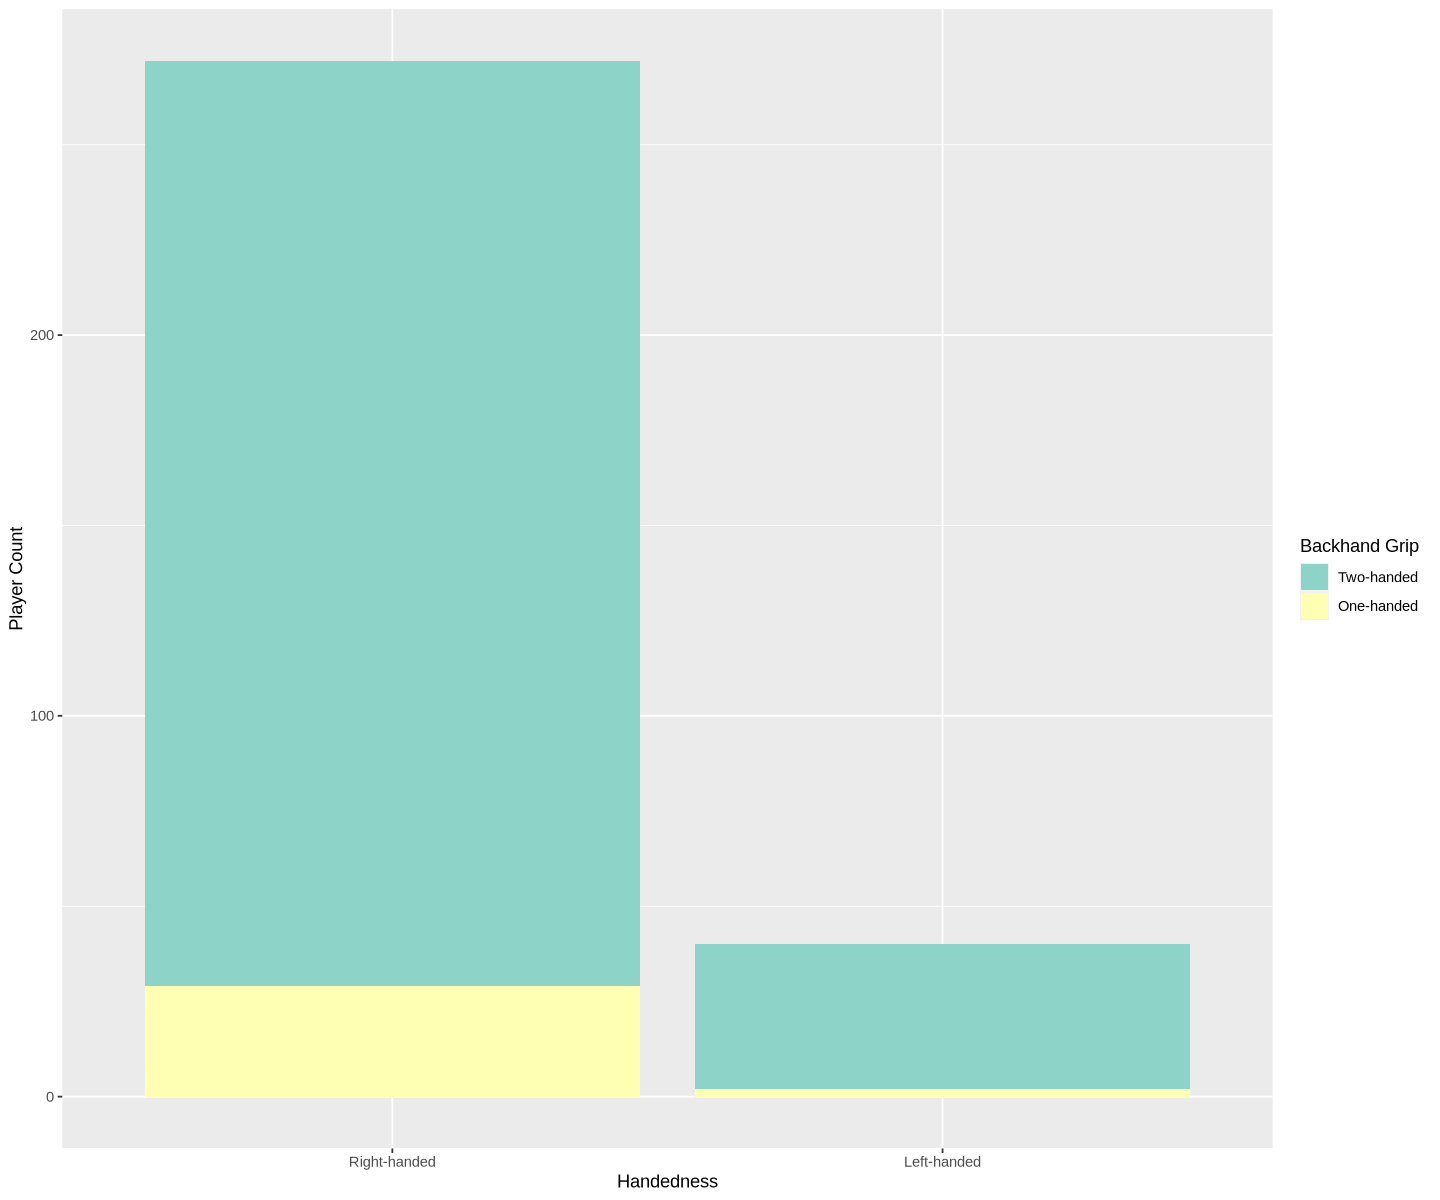

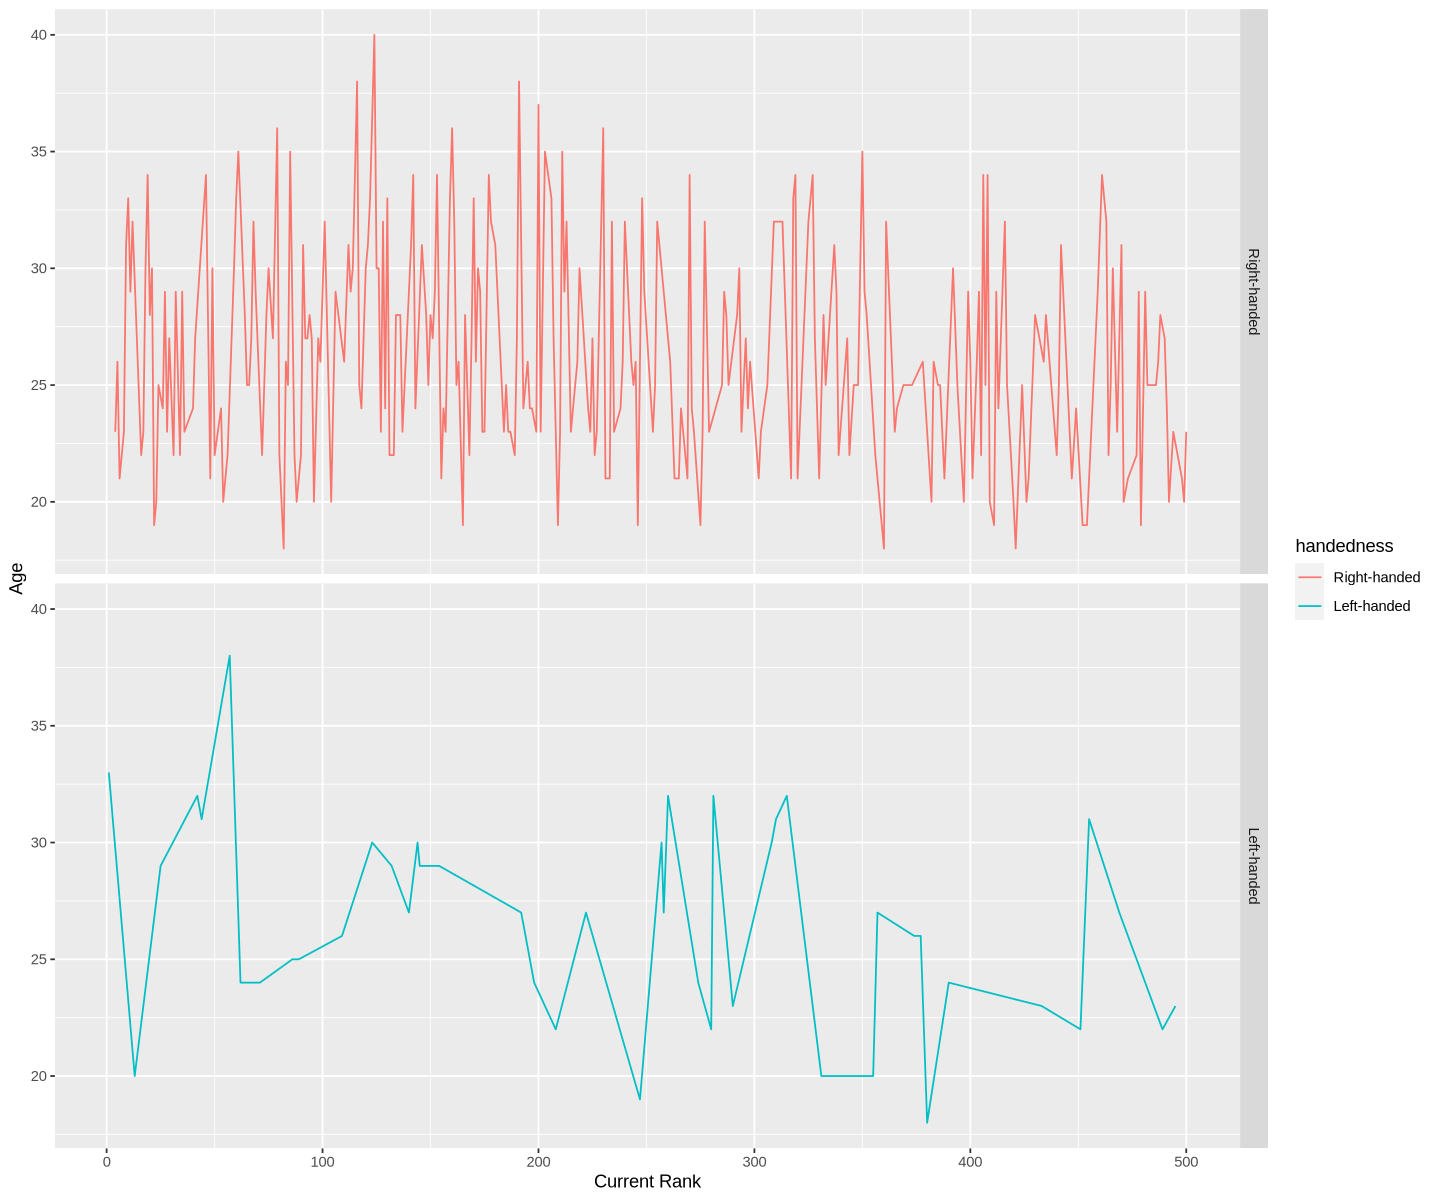

In [79]:
# visualizes the distribution of the handedness of players vs what their backhand grip is
handedness_backhand_distribution <- players_train |>
    filter(!is.na(handedness), !is.na(backhand_grip)) |>
    group_by(handedness, backhand_grip) |>
    summarize(count = n())

ggplot(handedness_backhand_distribution, aes(x = handedness, y = count, fill = backhand_grip)) + 
    geom_bar(stat = 'identity') +
    labs(x="Handedness", y = "Player Count", fill = "Backhand Grip") +
    scale_fill_brewer(palette = 'Set3')

# visualizes the distribution of age v.s. current rank of a player in respect to handedness
players_age_rank_handedness <- players_train |>
    filter(!is.na(handedness), !is.na(curr_rank), !is.na(age)) |>
    select(handedness, curr_rank, age)

ggplot(players_age_rank_handedness, aes(x = curr_rank, y = age, color = handedness)) +
    geom_line() +
    labs(x="Current Rank", y = "Age", fill = "Handedness") +
    facet_grid(rows = vars(handedness))